In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

### QUESTION 1: Exploratory Data Analysis

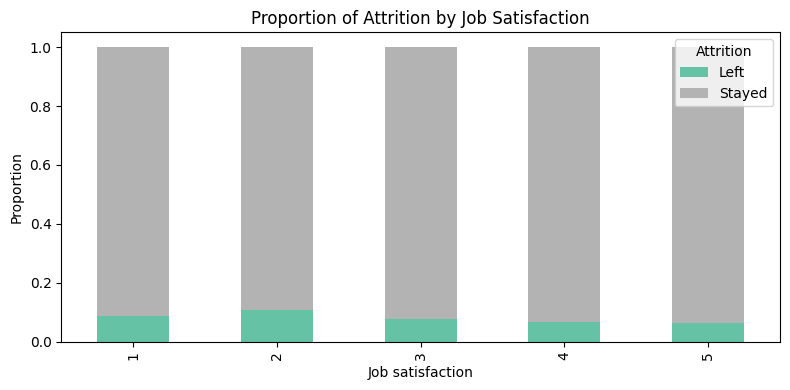

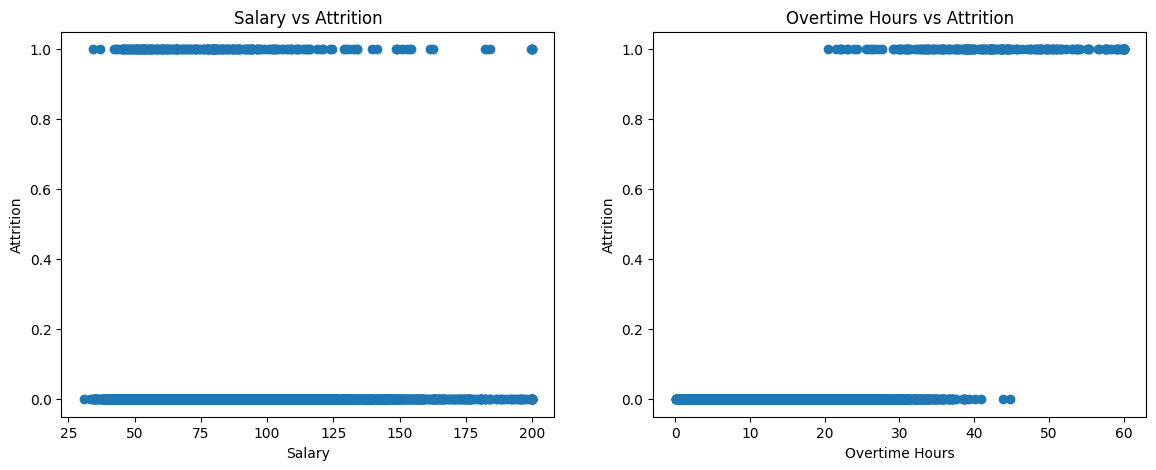

In [14]:
# a) Create visualizations showing the relationship between attrition and:
# - job_satisfaction (categorical)
# - salary (continuous)
# - overtime_hours (continuous)

# Load dataset
data = pd.read_csv('employee_attrition.csv')

data['attrition_label'] = data['attrition'].map({0: 'Stayed', 1: 'Left'})

# Visualization for job_satisfaction
ct = pd.crosstab(data['job_satisfaction'], data['attrition_label'], normalize='index')
ct.plot(kind='bar', stacked=True, figsize=(8,4), colormap='Set2')
plt.title('Proportion of Attrition by Job Satisfaction')
plt.xlabel('Job satisfaction')
plt.ylabel('Proportion')
plt.legend(title='Attrition')
plt.tight_layout()
plt.show()

# Visualization for salary
plt.figure(figsize=(14,5))
plt.subplot(1, 2, 1)
plt.scatter(data['salary'], data['attrition'])
plt.title('Salary vs Attrition')
plt.xlabel('Salary')
plt.ylabel('Attrition')

# Visualization for overtime_hours
plt.subplot(1, 2, 2)
plt.scatter(data['overtime_hours'], data['attrition'])
plt.title('Overtime Hours vs Attrition')
plt.xlabel('Overtime Hours')
plt.ylabel('Attrition')
plt.show()


In [16]:
# c) Calculate and interpret the correlation between 'years_at_company' and 'num_promotions'. Does this pose any econometric concerns?
correlation = data['years_at_company'].corr(data['num_promotions'])
print(f'Correlation between years_at_company and num_promotions: {correlation:.2f}')

Correlation between years_at_company and num_promotions: 0.68


### QUESTION 2: Linear Probability Model

In [25]:
# a) Estimate an Linear Probability Model using ALL independent variables (except monthly_income, which is perfectly collinear with salary). Use heteroskedasticity-robust standard errors.

# Define independent variables (excluding monthly_income)
X = data[['age', 'years_at_company', 'num_promotions', 'job_satisfaction', 'salary', 'overtime_hours']]
X = sm.add_constant(X)  # Add constant term for intercept

# Define dependent variable
y = data['attrition']

# Fit LPM model
model = sm.OLS(y, X).fit(cov_type='HC3')  # HC3 for heteroskedasticity-robust standard errors

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              attrition   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     159.2
Date:                Mon, 03 Nov 2025   Prob (F-statistic):          6.93e-176
Time:                        10:38:45   Log-Likelihood:                 660.63
No. Observations:                3000   AIC:                            -1307.
Df Residuals:                    2993   BIC:                            -1265.
Df Model:                           6                                         
Covariance Type:                  HC3                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0694      0.022  

In [20]:
# c) Check how many predicted probabilities fall outside [0,1]. What percentage is this? Why is this problematic?

predicted_probs = model.predict(X)
outside_bounds = ((predicted_probs < 0) | (predicted_probs > 1)).sum()
percentage_outside = (outside_bounds / len(predicted_probs)) * 100
print(f'Number of predicted probabilities outside [0,1]: {outside_bounds}')
print(f'Percentage of predicted probabilities outside [0,1]: {percentage_outside:.2f}%')

Number of predicted probabilities outside [0,1]: 1279
Percentage of predicted probabilities outside [0,1]: 42.63%


In [35]:
# d) For an employee with:
# - age = 30, years_at_company = 5, salary = 70, commute_distance = 15,
# - job_satisfaction = 3, work_life_balance = 2, num_promotions = 1,
# - training_hours = 25, performance_rating = 3.5, overtime_hours = 20,
# - num_projects = 4
# Calculate the predicted probability of attrition using the LPM.

new_employee = pd.DataFrame({
    'const': 1,
    'age': 30,
    'years_at_company': 5,
    'num_promotions': 1,
    'job_satisfaction': 3,
    'salary': 70,
    'overtime_hours': 20
}, index=[0])

predicted_prob = model.predict(new_employee)
print(f'Predicted probability of attrition for new employee: {predicted_prob[0]:.2f}')

Predicted probability of attrition for new employee: 0.17


### QUESTION 3: Logit Model

In [27]:
# a) Estimate a logit model using the same variables as Question 2.

logit_model = Logit(y, X).fit(disp=0)
print(logit_model.summary())

                           Logit Regression Results                           
Dep. Variable:              attrition   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2993
Method:                           MLE   Df Model:                            6
Date:                Mon, 03 Nov 2025   Pseudo R-squ.:                  0.7829
Time:                        11:08:50   Log-Likelihood:                -177.85
converged:                       True   LL-Null:                       -819.10
Covariance Type:            nonrobust   LLR p-value:                6.688e-274
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -7.9720      0.949     -8.402      0.000      -9.832      -6.112
age                 -0.0254      0.015     -1.712      0.087      -0.055       0.004
years_at_company    -0.1015 

In [32]:
# d) For the same employee profile in Question 2d, calculate the predicted probability using the logit model. Compare it to the LPM prediction.

# Define the employee profile (same as in Question 2d)
new_employee = pd.DataFrame({
    'const': 1,
    'age': 30,
    'years_at_company': 5,
    'num_promotions': 1,
    'job_satisfaction': 3,
    'salary': 70,
    'overtime_hours': 20
}, index=[0])

# Get predicted probabilities from both models
lpm_prediction = model.predict(new_employee)
logit_prediction = logit_model.predict(new_employee)

print(f"LPM Predicted Probability: {lpm_prediction[0]}")
print(f"Logit Predicted Probability: {logit_prediction[0]}")

LPM Predicted Probability: 0.1677107816014017
Logit Predicted Probability: 0.0063667856539343145


### QUESTION 4: Marginal Effects

In [ ]:
# a) Calculate Average Marginal Effects (AME) for the logit model for:
# - job_satisfaction
# - salary
# - overtime_hours

marginal_effects = logit_model.get_margeff(at='overall').summary()
print(marginal_effects)

        Logit Marginal Effects       
Dep. Variable:              attrition
Method:                          dydx
At:                           overall
                      dy/dx    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
age                 -0.0004      0.000     -1.721      0.085      -0.001    6.18e-05
years_at_company    -0.0018      0.001     -2.438      0.015      -0.003      -0.000
num_promotions      -0.0002      0.003     -0.095      0.924      -0.005       0.005
job_satisfaction    -0.0076      0.002     -3.428      0.001      -0.012      -0.003
salary              -0.0005    7.5e-05     -7.087      0.000      -0.001      -0.000
overtime_hours       0.0067      0.000     29.742      0.000       0.006       0.007


In [39]:
# b) Create a comparison table showing:
# - LPM coefficients
# - Logit AME
# - Logit coefficients (log-odds)
# - Logit odds ratios

# AME에 상수 추가 (NaN)
ame = logit_model.get_margeff(at='overall').margeff
ame_with_const = np.insert(ame, 0, np.nan)  # 상수 위치에 NaN 추가

comparison_table = pd.DataFrame({
    'LPM Coefficients': model.params,
    'Logit AME': ame_with_const,
    'Logit Coefficients': logit_model.params,
    'Logit Odds Ratios': np.exp(logit_model.params)
})
comparison_table


,LPM Coefficients,Logit AME,Logit Coefficients,Logit Odds Ratios
const,-0.069383,NaN,-7.971984,0.000345
age,-0.000069,-0.000444,-0.025433,0.974888
years_at_company,-0.001127,-0.001773,-0.101474,0.903505
num_promotions,-0.001403,-0.000241,-0.013816,0.986279
job_satisfaction,-0.007559,-0.007560,-0.432757,0.648718
salary,-0.000480,-0.000532,-0.030441,0.970018
overtime_hours,0.015123,0.006669,0.381751,1.464847


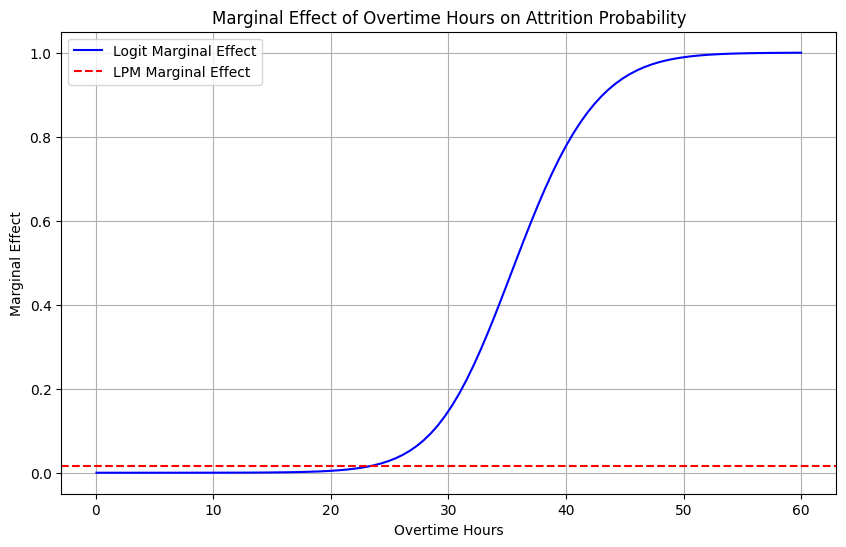

In [40]:
# d) Create a visualization showing how the marginal effect of overtime_hours varies with the baseline probability of attrition in the logit model. Compare this to the constant marginal effect in the LPM.

overtime_range = np.linspace(data['overtime_hours'].min(), data['overtime_hours'].max(), 100)
baseline_probs = []
for hours in overtime_range:
    temp_X = X.copy()
    temp_X['overtime_hours'] = hours
    probs = logit_model.predict(temp_X)
    baseline_probs.append(probs.mean())

lpm_marginal_effect = model.params['overtime_hours']

plt.figure(figsize=(10, 6))
plt.plot(overtime_range, baseline_probs, label='Logit Marginal Effect', color='blue')
plt.axhline(y=lpm_marginal_effect, color='red', linestyle='--', label='LPM Marginal Effect')
plt.title('Marginal Effect of Overtime Hours on Attrition Probability')
plt.xlabel('Overtime Hours')
plt.ylabel('Marginal Effect')
plt.legend()
plt.grid()
plt.show()

### QUESTION 5: Model Comparison - Why LPM ≠ Logit

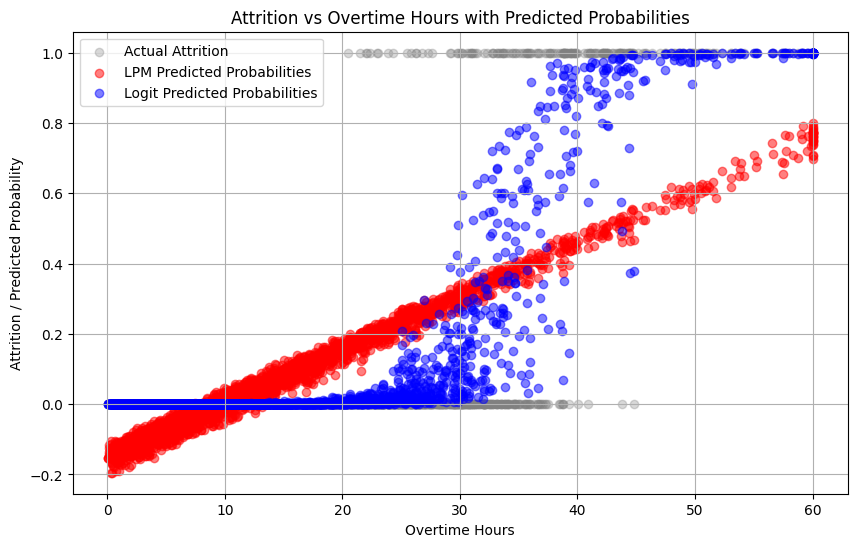

In [ ]:
# a) Create a scatter plot showing:
# - X-axis: overtime_hours
# - Y-axis: attrition (0 or 1)
# - Overlay predicted probabilities from both LPM and Logit

plt.figure(figsize=(10, 6))
plt.scatter(data['overtime_hours'], data['attrition'], alpha=0.3, label='Actual Attrition', color='gray')
plt.scatter(data['overtime_hours'], predicted_probs, color='red', alpha=0.5, label='LPM Predicted Probabilities')
logit_predicted_probs = logit_model.predict(X)
plt.scatter(data['overtime_hours'], logit_predicted_probs, color='blue', alpha=0.5, label='Logit Predicted Probabilities')
plt.title('Attrition vs Overtime Hours with Predicted Probabilities')
plt.xlabel('Overtime Hours')
plt.ylabel('Attrition / Predicted Probability')
plt.legend()
plt.grid()
plt.show()

In [42]:
# c) Calculate and compare the following for both models:
# - R-squared (for LPM) / Pseudo R-squared (for Logit)
# - AUC-ROC
# - Accuracy (at threshold = 0.5)

lpm_r_squared = model.rsquared
logit_pseudo_r_squared = logit_model.prsquared
print(f'LPM R-squared: {lpm_r_squared:.4f}')
print(f'Logit Pseudo R-squared: {logit_pseudo_r_squared:.4f}')
lpm_auc = roc_auc_score(y, predicted_probs)
logit_auc = roc_auc_score(y, logit_predicted_probs)
print(f'LPM AUC-ROC: {lpm_auc:.4f}')
print(f'Logit AUC-ROC: {logit_auc:.4f}')
lpm_predictions_binary = (predicted_probs >= 0.5).astype(int)
logit_predictions_binary = (logit_predicted_probs >= 0.5).astype(int)
lpm_accuracy = (lpm_predictions_binary == y).mean()
logit_accuracy = (logit_predictions_binary == y).mean()
print(f'LPM Accuracy: {lpm_accuracy:.4f}')
print(f'Logit Accuracy: {logit_accuracy:.4f}')

LPM R-squared: 0.4738
Logit Pseudo R-squared: 0.7829
LPM AUC-ROC: 0.9888
Logit AUC-ROC: 0.9908
LPM Accuracy: 0.9607
Logit Accuracy: 0.9770


### QUESTION 6: Threshold Selection
Suppose the costs of errors are:
- False Positive (predict attrition, but employee stays): $5,000
(unnecessary retention bonus/intervention)
- False Negative (predict retention, but employee leaves): $50,000
(cost of recruitment, training, lost productivity)

In [43]:
# a) Find the cost-optimal threshold for the logit model.

thresholds = np.linspace(0, 1, 100)
costs = []
for threshold in thresholds:
    predictions = (logit_predicted_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
    total_cost = (fp * 5000) + (fn * 50000)
    costs.append(total_cost)
optimal_threshold = thresholds[np.argmin(costs)]
print(f'Optimal Threshold: {optimal_threshold:.4f}')

Optimal Threshold: 0.2424


In [44]:
# c) Calculate the expected cost per employee under both thresholds. How much money would the company save by using the optimal threshold?

# Calculate expected cost per employee at threshold = 0.5
predictions_05 = (logit_predicted_probs >= 0.5).astype(int)
tn, fp, fn, tp = confusion_matrix(y, predictions_05).ravel()    
expected_cost_05 = (fp * 5000 + fn * 50000) / len(y)

# Calculate expected cost per employee at optimal threshold
predictions_optimal = (logit_predicted_probs >= optimal_threshold).astype(int)
tn, fp, fn, tp = confusion_matrix(y, predictions_optimal).ravel()
expected_cost_optimal = (fp * 5000 + fn * 50000) / len(y)

# Calculate savings
savings = expected_cost_05 - expected_cost_optimal
print(f'Expected Cost per Employee at 0.5 Threshold: ${expected_cost_05:.2f}')
print(f'Expected Cost per Employee at Optimal Threshold: ${expected_cost_optimal:.2f}')
print(f'Savings per Employee by using Optimal Threshold: ${savings:.2f}')

Expected Cost per Employee at 0.5 Threshold: $760.00
Expected Cost per Employee at Optimal Threshold: $456.67
Savings per Employee by using Optimal Threshold: $303.33


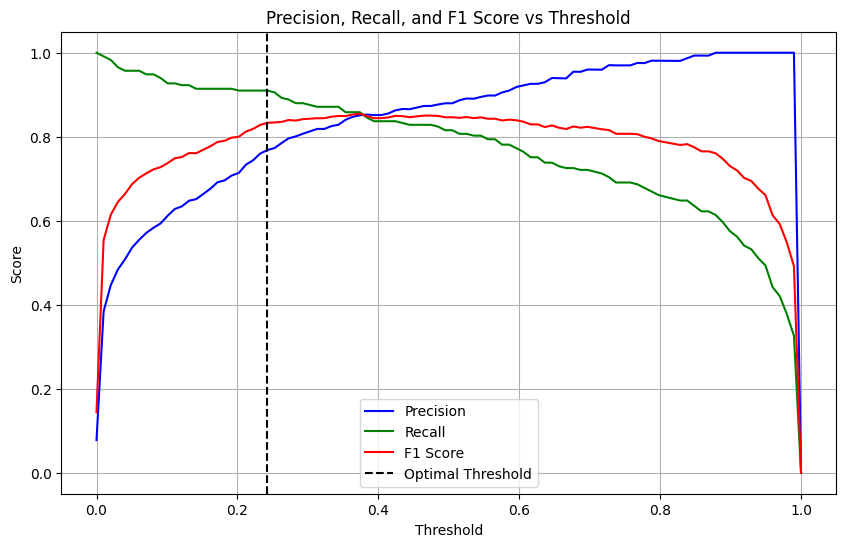

In [45]:
# d) Plot how Precision, Recall, and F1 change across different thresholds. Mark the cost-optimal threshold on this plot.

precisions = []
recalls = []
f1_scores = []
for threshold in thresholds:
    predictions = (logit_predicted_probs >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.plot(thresholds, f1_scores, label='F1 Score', color='red')
plt.axvline(x=optimal_threshold, color='black', linestyle='--', label='Optimal Threshold')
plt.title('Precision, Recall, and F1 Score vs Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()

### QUESTION 7: Regularized Logit

In [48]:
# a) Fit both L1 (Lasso) and L2 (Ridge) regularized logit models with C=1.0. Remember to standardize your features first


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.drop(columns='const'))

logit_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
logit_l2 = LogisticRegression(penalty='l2', C=1.0)

logit_l1.fit(X_scaled, y)
logit_l2.fit(X_scaled, y)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [49]:
# b) Compare the coefficients from:
# - Unregularized logit
# - L1 regularized logit
# - L2 regularized logit

unregularized_coeffs = logit_model.params
l1_coeffs = pd.Series(logit_l1.coef_[0], index=X.columns[1:])  # Exclude constant
l2_coeffs = pd.Series(logit_l2.coef_[0], index=X.columns[1:])  # Exclude constant

coeffs_comparison = pd.DataFrame({
    'Unregularized': unregularized_coeffs,
    'L1 Regularized': l1_coeffs,
    'L2 Regularized': l2_coeffs
})
coeffs_comparison

,Unregularized,L1 Regularized,L2 Regularized
age,-0.025433,-0.196141,-0.200376
const,-7.971984,NaN,NaN
job_satisfaction,-0.432757,-0.409172,-0.408215
num_promotions,-0.013816,-0.003539,-0.020996
overtime_hours,0.381751,4.310276,4.184442
salary,-0.030441,-0.949521,-0.929376
years_at_company,-0.101474,-0.430134,-0.422740


In [ ]:
# c) Which variables (if any) does L1 regularization shrink to zero?

shrunk_to_zero = l1_coeffs[abs(l1_coeffs) < 1e-6].index.tolist()
print(f'Variables shrunk to zero by L1 regularization: {shrunk_to_zero}')


Variables shrunk to zero by L1 regularization: []
